Notes:
- It might be worth trying the multiple classifiers on the image data with continual learning + delegation
- This notebook will look into training classifiers on multiple labels or some weighted combination of labels (i.e. 100% of 1 and 20% of 7)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
from matplotlib.animation import FuncAnimation

In [2]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load MNIST dataset
mnist_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes for MNIST digits

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [69]:
class Voter:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.pw_acc = []
        self.ucb_scores = []
        self.num_predictions = [0]

    def vote(self, x):
        self.model.eval()
        logits = self.model.forward(x)
        return torch.argmax(logits, dim=1)

In [222]:
# function to calculate the ucb score
def ucb_score(mean, t, n_t, c=3):
    return mean + c * np.sqrt(np.log(t) / (n_t + 1e-8))


# try it out
values = np.zeros(10)
values[0] = 1
mean = np.mean(values)

print(ucb_score(mean, 100, len(values)))
print(ucb_score(mean, 100, len(values), c=0.5))

values = np.zeros(100)
values[:10] = 1
mean = np.mean(values)

print(ucb_score(mean, 100, len(values)))

values = np.zeros(100)
values[:55] = 1
mean = np.mean(values)

print(ucb_score(mean, 100, len(values)))

2.1358421263066125
0.4393070210511021
0.7437898078546148
1.193789807854615


- continual learning
- 2 classes 2 classifiers
- delegate to classifier with highest UCB score
- delegations are updated after each batch
- non-gurus dont predict

In [257]:
# sort the training data into ascending order of label
sorted_train_data = sorted(
    [(x, y) for x, y in zip(mnist_train.data, mnist_train.targets)], key=lambda x: x[1]
)

# only keep classs 0 and 1
sorted_train_data = [x for x in sorted_train_data if x[1] <= 1]

batch_size = 100
# create a dataloader with the sorted data
train_loader = DataLoader(sorted_train_data, batch_size=batch_size, shuffle=False)



In [258]:
# Assuming the necessary imports and class definitions (like Net, Voter, etc.) are already done

model = [Net().to(device) for _ in range(2)]
criterion = nn.CrossEntropyLoss()
optimizer = [optim.Adam(m.parameters(), lr=0.001) for m in model]

voters = [Voter(m, criterion, o) for m, o in zip(model, optimizer)]

t = 0

for batch_idx, (x, y) in enumerate(tqdm(train_loader)):
    x, y = x.to(device).float(), y.to(device)  # Assuming y should be Long type for criterion
    batch_size = x.size(0)
    t += batch_size

    if batch_idx == 0:
        # Train both models on the first batch
        for voter in voters:
            voter.model.train()
            voter.optimizer.zero_grad()
            logits = voter.model(x)
            loss = voter.criterion(logits, y)
            loss.backward()
            voter.optimizer.step()

            # Calculate the accuracy
            voter.model.eval()
            with torch.no_grad():
                logits = voter.model(x)
                pred = torch.argmax(logits, dim=1)
                batch_pw_acc = pred.eq(y).float()
                voter.pw_acc.extend(batch_pw_acc.cpu().numpy())
                voter.num_predictions.append(voter.num_predictions[-1] + batch_size)
    else:
        # Calculate the UCB scores for each model
        ucb_scores = []
        for voter in voters:
            ucb_val = ucb_score(np.mean(voter.pw_acc), t, len(voter.pw_acc))
            ucb_scores.append(ucb_val)
            voter.ucb_scores.append(ucb_val)
        # Choose the model with the highest UCB score
        best_model_idx = np.argmax(ucb_scores)

        # Predict with the best model, then train it on the batch
        voters[best_model_idx].model.eval()
        with torch.no_grad():
            logits = voters[best_model_idx].model(x)
            pred = torch.argmax(logits, dim=1)
            batch_pw_acc = [1 if pred[i] == y[i] else 0 for i in range(len(pred))]
            voters[best_model_idx].pw_acc.extend(batch_pw_acc)
            voters[best_model_idx].num_predictions.append(
                voters[best_model_idx].num_predictions[-1] + len(batch_pw_acc)
            )
            # update the other model num_predictions
            for i in range(len(voters)):
                if i != best_model_idx:
                    voters[i].num_predictions.append(voters[i].num_predictions[-1])

        # Train the best model on the batch
        voters[best_model_idx].model.train()
        voters[best_model_idx].optimizer.zero_grad()
        logits = voters[best_model_idx].model(x)
        loss = voters[best_model_idx].criterion(logits, y)
        loss.backward()
        voters[best_model_idx].optimizer.step()


100%|██████████| 127/127 [00:00<00:00, 212.53it/s]


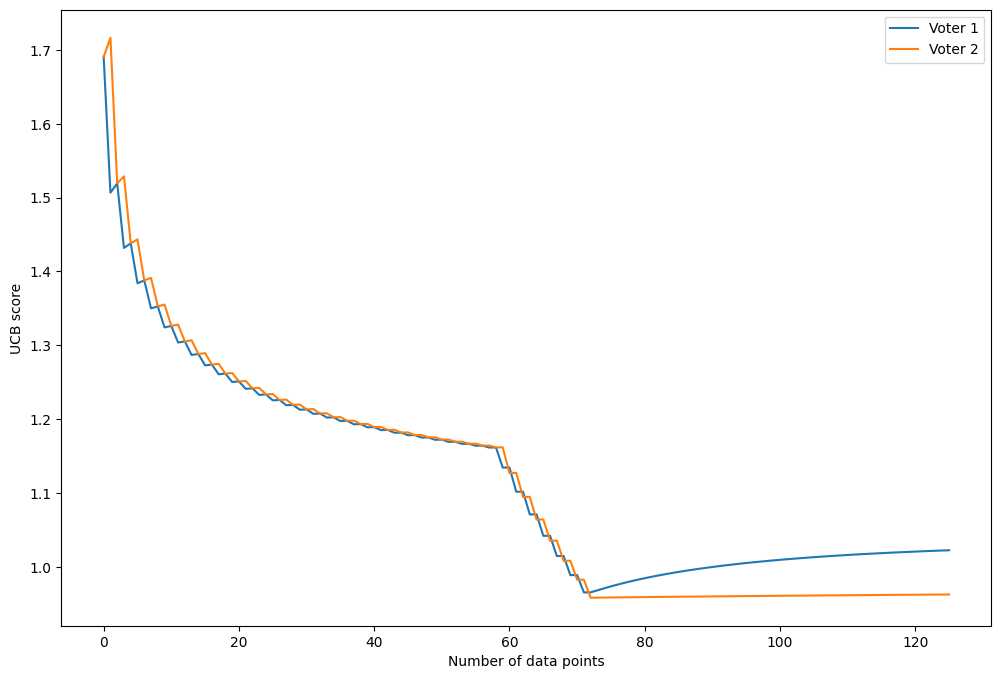

In [259]:
voter_1_ucb = voters[0].ucb_scores
voter_2_ucb = voters[1].ucb_scores

# Plot the UCB scores
plt.figure(figsize=(12, 8))
plt.plot(voter_1_ucb, label="Voter 1")
plt.plot(voter_2_ucb, label="Voter 2")
plt.xlabel("Number of data points")
plt.ylabel("UCB score")
# plt.ylim(1.015, 1.04)
plt.legend()

In [260]:
# plot the len of the accuracy list for each voter
voter_1_len = len(voters[0].pw_acc)
voter_2_len = len(voters[1].pw_acc)
# print(voters[0].num_predictions[-1])
# print(voters[1].num_predictions[-1])

print("voters[0].num_predictions[-1] ", voters[0].num_predictions[-1])
print("voters[1].num_predictions[-1] ", voters[1].num_predictions[-1])
print("t ", t)
print('voter_1_len ', voter_1_len)
print('voter_2_len ', voter_2_len)
print('voter_1_len + voter_2_len  ', voter_1_len + voter_2_len)
print('len(train_loader.dataset) ', len(train_loader.dataset))


voters[0].num_predictions[-1]  9065
voters[1].num_predictions[-1]  3700
t  12665
voter_1_len  9065
voter_2_len  3700
voter_1_len + voter_2_len   12765
len(train_loader.dataset)  12665


128
128
9065
3700


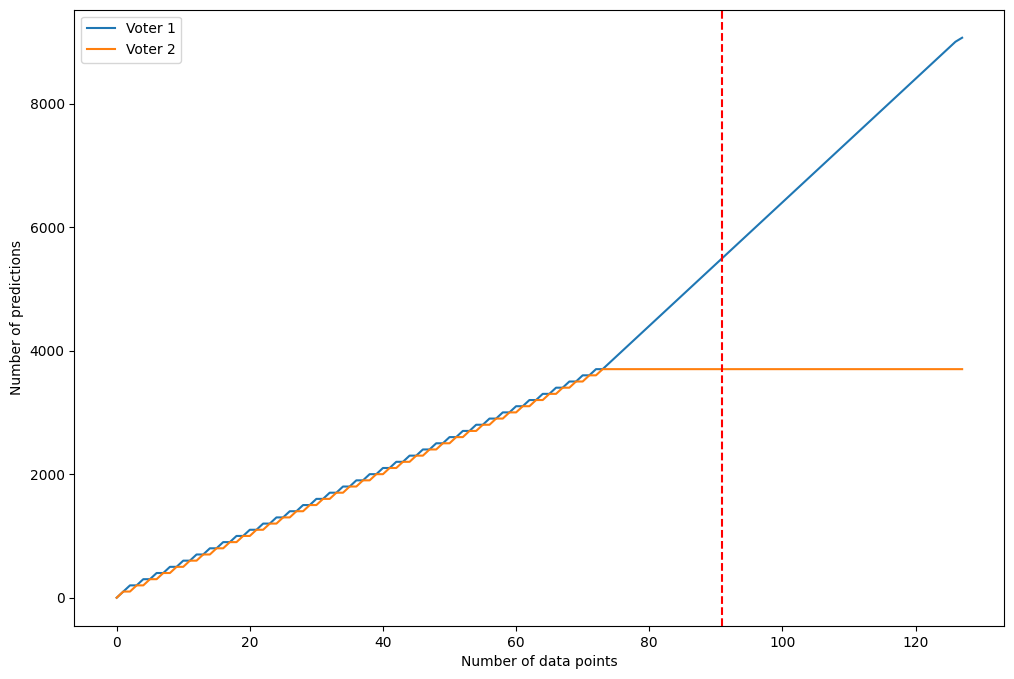

In [261]:
voter_1_num_predictions = voters[0].num_predictions
voter_2_num_predictions = voters[1].num_predictions

# find the points where the labels change
label_change_points = []
for i in range(1, len(sorted_train_data)):
    if sorted_train_data[i][1] != sorted_train_data[i - 1][1]:
        label_change_points.append(i)

# divide change points by batch size
label_change_points = [i // batch_size for i in label_change_points]

print(len(voter_1_num_predictions))
print(len(voter_2_num_predictions))

print(voter_1_num_predictions[-1])
print(voter_2_num_predictions[-1])

plt.figure(figsize=(12, 8))
plt.plot(voter_1_num_predictions, label="Voter 1")
plt.plot(voter_2_num_predictions, label="Voter 2")
#plot label change points
for i in label_change_points:
    plt.axvline(x=i, color="red", linestyle="--")
plt.xlabel("Number of data points")
plt.ylabel("Number of predictions")
plt.legend()

plt.show()

In [262]:
# Filter the test dataset for examples with label 0
test_0_data = [x for x in mnist_test if x[1] == 0]
print("Number of test examples with label 0:", len(test_0_data))

# Prepare the test data
test_0_x = torch.stack([x[0] for x in test_0_data])
test_0_y = torch.tensor([x[1] for x in test_0_data])

# Move the data to the specified device
test_0_x = test_0_x.to(device).float()
test_0_y = test_0_y.to(device)

# Evaluate each voter model
for i, voter in enumerate(voters):
    voter.model.eval()
    with torch.no_grad():
        test_0_logits = voter.model(test_0_x)
        test_0_pred = torch.argmax(test_0_logits, dim=1)
        test_0_acc = (test_0_pred == test_0_y).float().mean()

    print(f"Voter {i+1} accuracy on test set with 0 label: {test_0_acc:.4f}")



Number of test examples with label 0: 980
Voter 1 accuracy on test set with 0 label: 0.1837
Voter 2 accuracy on test set with 0 label: 1.0000


In [263]:
# Filter the test dataset for examples with label 1
test_1_data = [x for x in mnist_test if x[1] == 1]
print("Number of test examples with label 1:", len(test_1_data))

# Prepare the test data
test_1_x = torch.stack([x[0] for x in test_1_data])
test_1_y = torch.tensor([x[1] for x in test_1_data])

# Move the data to the specified device
test_1_x = test_1_x.to(device).float()
test_1_y = test_1_y.to(device)

# Evaluate each voter model
for i, voter in enumerate(voters):
    voter.model.eval()
    with torch.no_grad():
        test_1_logits = voter.model(test_1_x)
        test_1_pred = torch.argmax(test_1_logits, dim=1)
        test_1_acc = (test_1_pred == test_1_y).float().mean()

    print(f"Voter {i+1} accuracy on test set with 1 label: {test_1_acc:.4f}")

Number of test examples with label 1: 1135
Voter 1 accuracy on test set with 1 label: 0.0767
Voter 2 accuracy on test set with 1 label: 0.0000


In [247]:
# Filter the test dataset for examples with label 2
test_2_data = [x for x in mnist_test if x[1] == 2]
print("Number of test examples with label 2:", len(test_2_data))

# Prepare the test data
test_2_x = torch.stack([x[0] for x in test_2_data])
test_2_y = torch.tensor([x[1] for x in test_2_data])

# Move the data to the specified device
test_2_x = test_2_x.to(device).float()
test_2_y = test_2_y.to(device)

# Evaluate each voter model
for i, voter in enumerate(voters):
    voter.model.eval()
    with torch.no_grad():
        test_2_logits = voter.model(test_2_x)
        test_2_pred = torch.argmax(test_2_logits, dim=1)
        test_2_acc = (test_2_pred == test_2_y).float().mean()

    print(f"Voter {i+1} accuracy on test set with 2 label: {test_2_acc:.4f}")

Number of test examples with label 2: 1032
Voter 1 accuracy on test set with 2 label: 0.0359
Voter 2 accuracy on test set with 2 label: 0.0000


In [249]:
# Filter the test dataset for examples with label 3
test_3_data = [x for x in mnist_test if x[1] == 3]
print("Number of test examples with label 3:", len(test_3_data))

# Prepare the test data
test_3_x = torch.stack([x[0] for x in test_3_data])
test_3_y = torch.tensor([x[1] for x in test_3_data])

# Move the data to the specified device
test_3_x = test_3_x.to(device).float()
test_3_y = test_3_y.to(device)

# Evaluate each voter model
for i, voter in enumerate(voters):
    voter.model.eval()
    with torch.no_grad():
        test_3_logits = voter.model(test_3_x)
        test_3_pred = torch.argmax(test_3_logits, dim=1)
        test_3_acc = (test_3_pred == test_3_y).float().mean()

    print(f"Voter {i+1} accuracy on test set with 3 label: {test_3_acc:.4f}")
    # print(f"Voter {i+1} preds on test set with 3 label: {test_3_pred}")

Number of test examples with label 3: 1010
Voter 1 accuracy on test set with 3 label: 0.0040
Voter 2 accuracy on test set with 3 label: 1.0000


In [238]:
# print voter 2s predictions on label 3
print(test_3_pred)
print(test_3_y)


tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([3, 3, 3,  ..., 3, 3, 3])
